# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [6]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [7]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [8]:
pb_dir_path = '../../data/pseudobulks/'

In [9]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [10]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [11]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [12]:
import pickle
with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [13]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [14]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [15]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [16]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [17]:
cs_genes = genes_dict77['chimp']

In [18]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_cs = df[cs_genes]

## Hierarchial

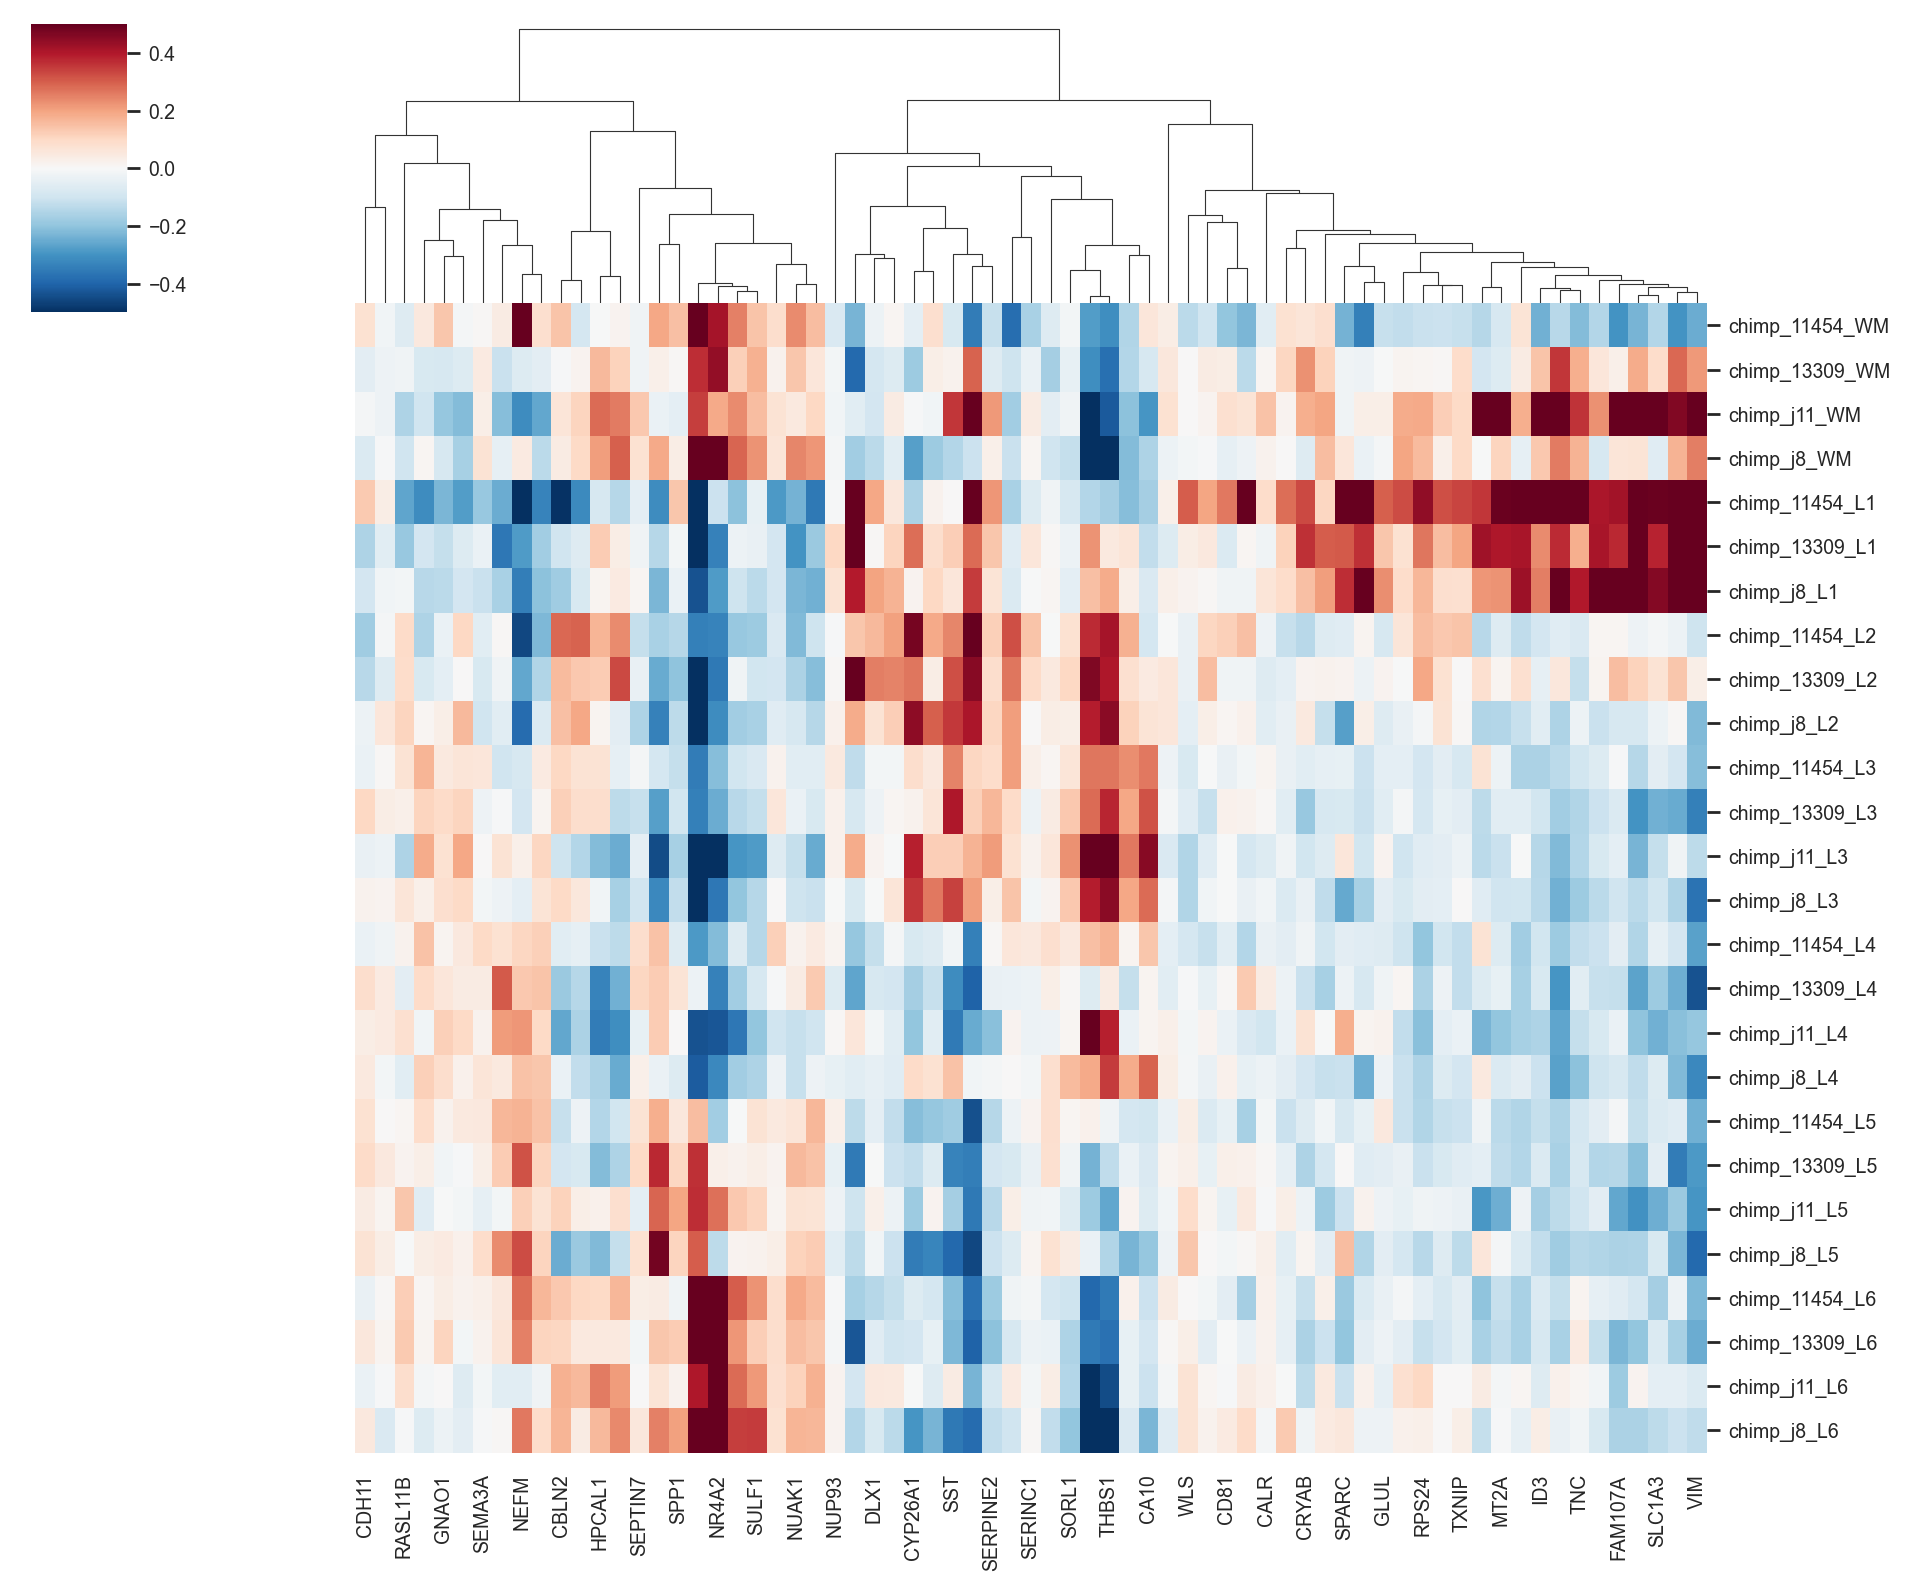

In [19]:
sns.set(font_scale=0.8)
sns.clustermap(df_cs.loc[sample_order['chimp']], figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [20]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_cs.loc[sample_order['chimp']].T, metric='cosine') + 1
n_clusters = 3
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=3,
                   random_state=4)

In [21]:
labels = pd.Series(clustering.labels_, index=cs_genes).sort_values()
order = labels.sort_values().index

In [22]:
labels.to_csv('./results/chimp_clusters_50.csv')

In [23]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

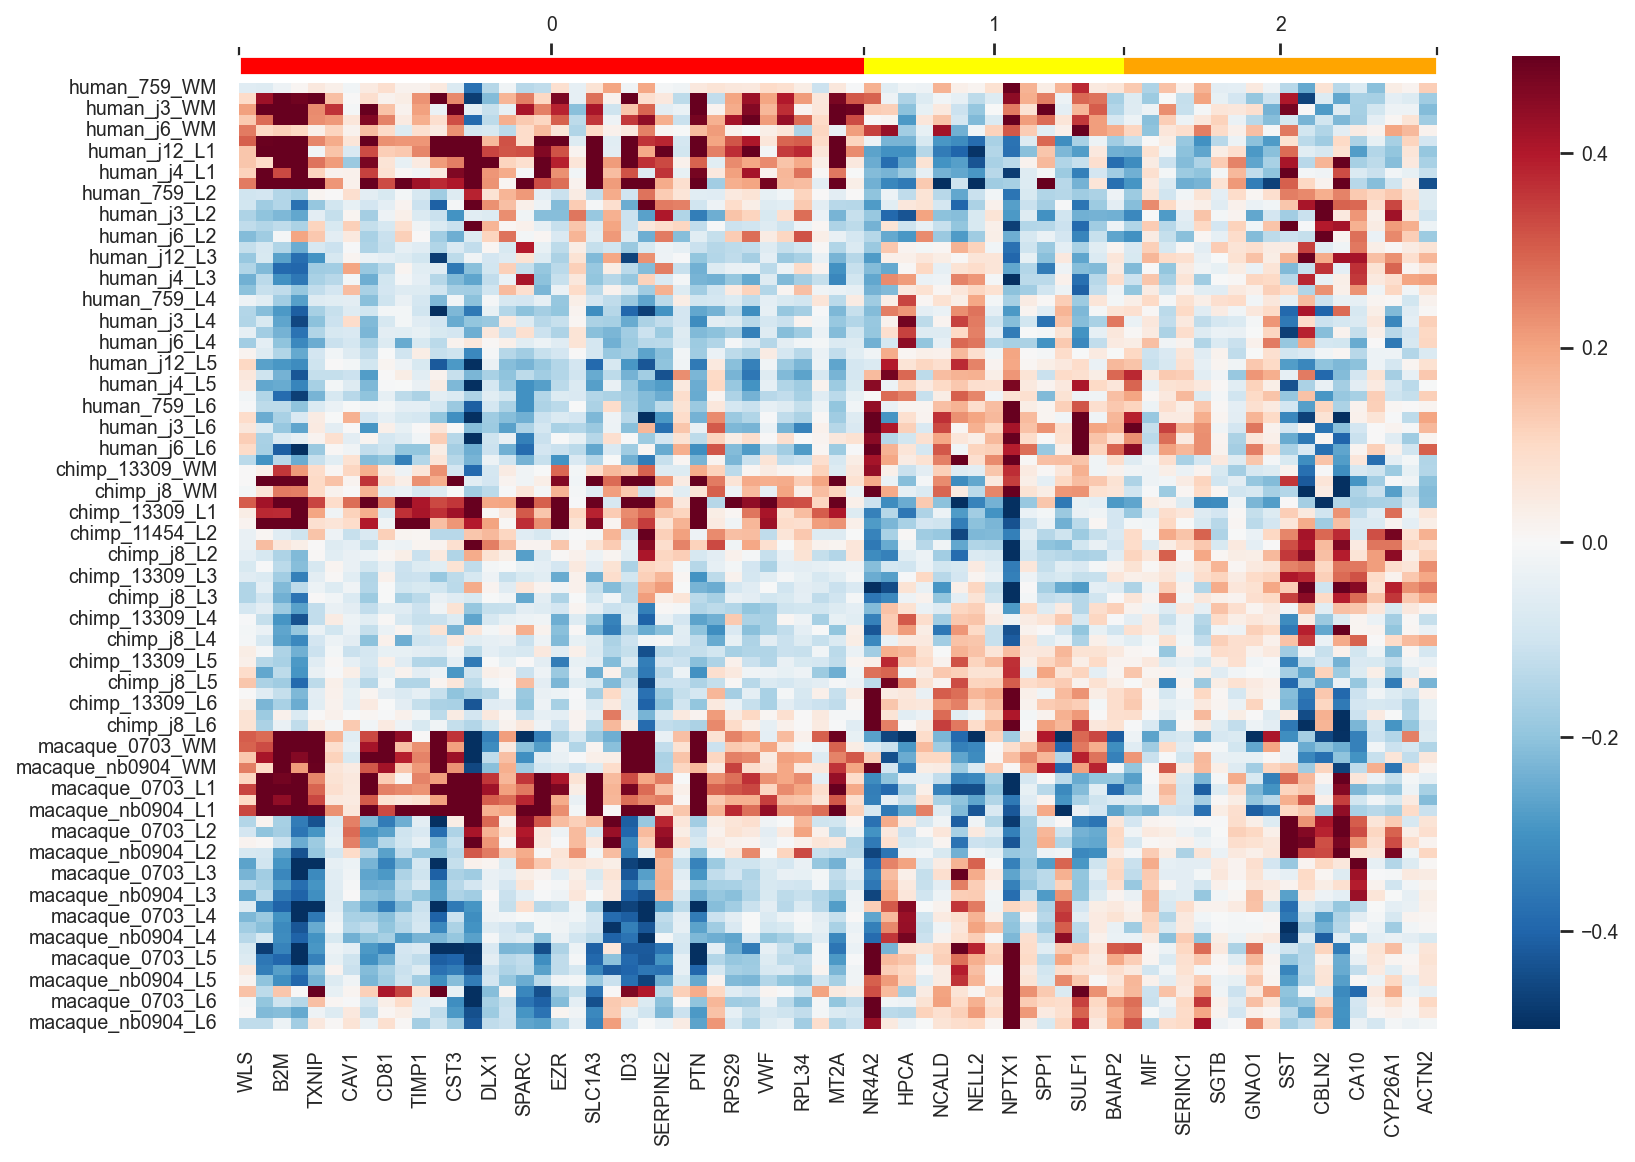

In [24]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_cs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles

In [25]:
df_annotation = df_cs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [26]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTN2       B2M    BAIAP2      CA10     CALB2      CALR  \
condition layer                                                               
chimp     L1    -0.037919  0.595289 -0.156733 -0.122817  0.076765  0.044611   
          L2     0.125905 -0.053018 -0.076051  0.008264  0.410350 -0.049035   
          L3     0.220166 -0.193069  0.003935  0.330599  0.422841 -0.016073   
          L4     0.011400 -0.252516 -0.002536  0.115004  0.213624 -0.030577   
          L5    -0.084475 -0.155601  0.028117 -0.108413 -0.105568  0.003552   

                     CAV1     CBLN2      CD81     CDH11  ...     STMN4  \
condition layer                                          ...             
chimp     L1     0.162743 -0.257330  0.057599 -0.038049  ... -0.145968   
          L2    -0.068602  0.197283  0.035114 -0.115456  ...  0.089293   
          L3    -0.046583  0.055974 -0.003908  0.012917  ...  0.117811   
          L4    -0.041992 -0.133812 -0.014701  0.035265  ...  0.054108   
          L5    -0.044614 -0.085236 -0.016032  0.071576  ...  0.013794   

                    SULF1     THBS1     TIMP1       TNC     TTC9B     TXNIP  \
condition layer                                                               
chimp     L1    -0.069200  0.020860  0.496047  0.389122 -0.261858  0.205767   
          L2    -0.147644  0.423602 -0.030092 -0.074288 -0.153288  0.050053   
          L3    -0.155280  0.458362 -0.097861 -0.143751 -0.123638 -0.041057   
          L4    -0.144975  0.238344 -0.101084 -0.125281  0.013730 -0.092429   
          L5     0.059881 -0.139947 -0.100367 -0.104265  0.127470 -0.083507   

                      VIM       VWF       WLS  
condition layer                                
chimp     L1     1.176994  0.514796  0.118497  
          L2    -0.096151 -0.053905 -0.041218  
          L3    -0.263862 -0.078054 -0.110761  
          L4    -0.305315 -0.139120 -0.030191  
          L5    -0.302764 -0.099536  0.073160  

[5 rows x 69 columns]

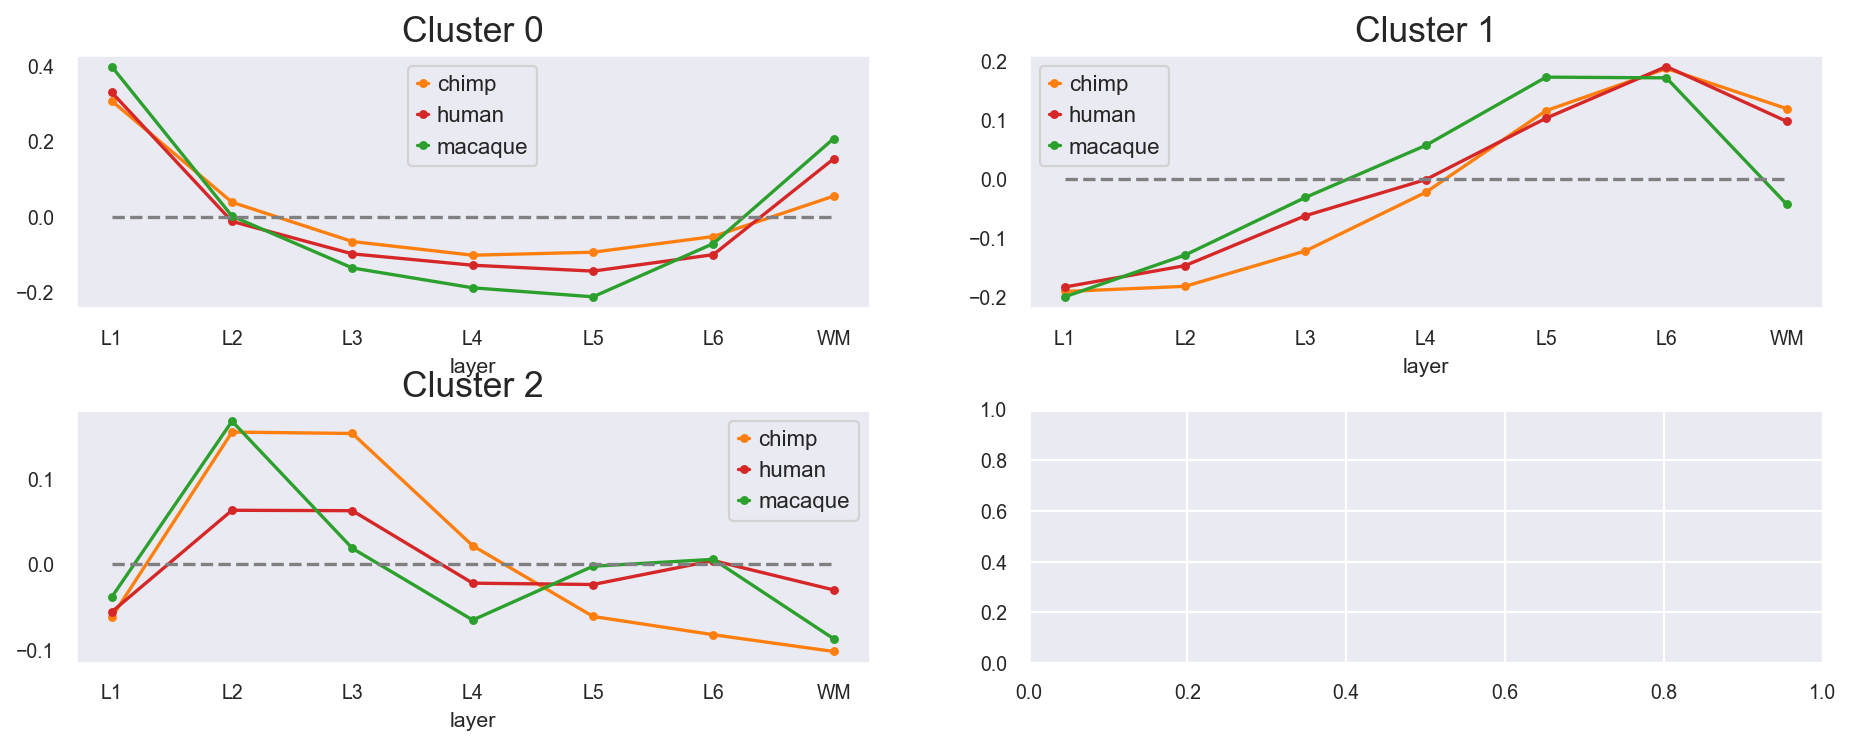

In [27]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [28]:
anova_cs_inter = cs_genes.intersection(anova_labels.index)
anova_cs_inter

Index(['ACTN2', 'BAIAP2', 'CA10', 'CALB2', 'CALR', 'CAV1', 'CBLN2', 'CD81',
       'CDH11', 'CRYAB', 'CRYM', 'CST3', 'CXCL14', 'CYP26A1', 'DLX1', 'EZR',
       'FBLN1', 'GLUL', 'GNAO1', 'HPCA', 'HPCAL1', 'ID3', 'IGFBP5', 'KIT',
       'LMO3', 'MASP1', 'MCUB', 'MIF', 'NCALD', 'NEFM', 'NELL2', 'NPTX1',
       'NR4A2', 'NUAK1', 'NUP93', 'RASL11B', 'RIPOR2', 'RNF2', 'RPL26',
       'RPS29', 'SDCCAG8', 'SEMA3A', 'SEPTIN7', 'SERINC1', 'SERPINE2', 'SGTB',
       'SLC1A3', 'SORL1', 'SPARC', 'SPP1', 'SST', 'STMN4', 'SULF1', 'THBS1',
       'TTC9B', 'TXNIP', 'VIM', 'VWF', 'WLS'],
      dtype='object')

In [29]:
table_to_pivot = pd.concat([anova_labels.loc[anova_cs_inter], labels.loc[anova_cs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels,0,1,2
ANOVA_labels,,,
0,2.0,0.0,4.0
1,0.0,7.0,1.0
2,1.0,2.0,5.0
3,5.0,3.0,1.0
4,6.0,1.0,2.0
5,0.0,2.0,5.0
6,12.0,0.0,0.0


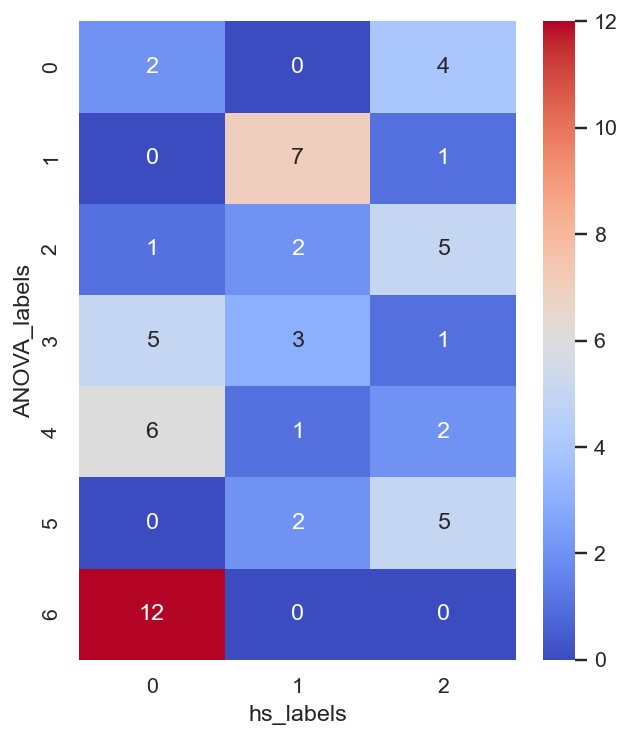

In [30]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

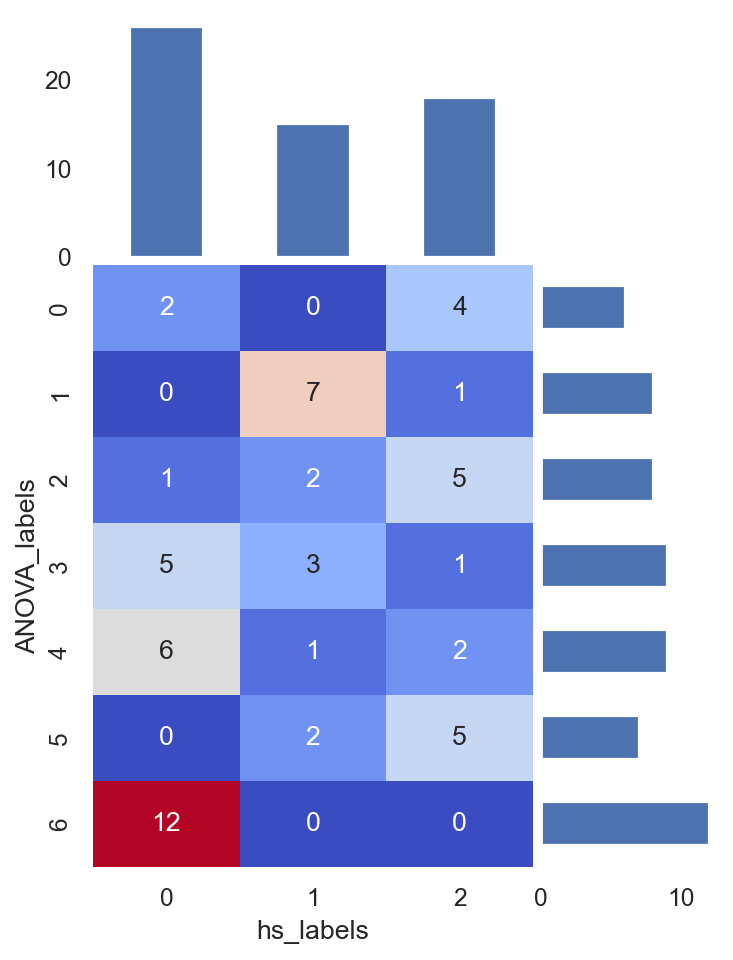

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [32]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/3 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [60]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [61]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
cellular protein metabolic process (GO:0044267),1,6.001584e-07,11.516796,164.990449,"[CST3, IGFBP5, RPS29, RPL34, TNC, RPL38, TIMP1...",0.000510,0,0,9,3.292826,0
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),2,3.476908e-06,26.255760,330.018293,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000938,0,0,5,3.027865,0
cotranslational protein targeting to membrane (GO:0006613),3,4.418624e-06,24.912521,307.163458,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000938,0,0,5,3.027865,0
cytoplasmic translation (GO:0002181),4,4.418624e-06,24.912521,307.163458,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000938,0,0,5,3.027865,0
protein targeting to ER (GO:0045047),5,7.928128e-06,21.918633,257.436391,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.001346,0,0,5,2.870892,0


In [62]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

14

In [63]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

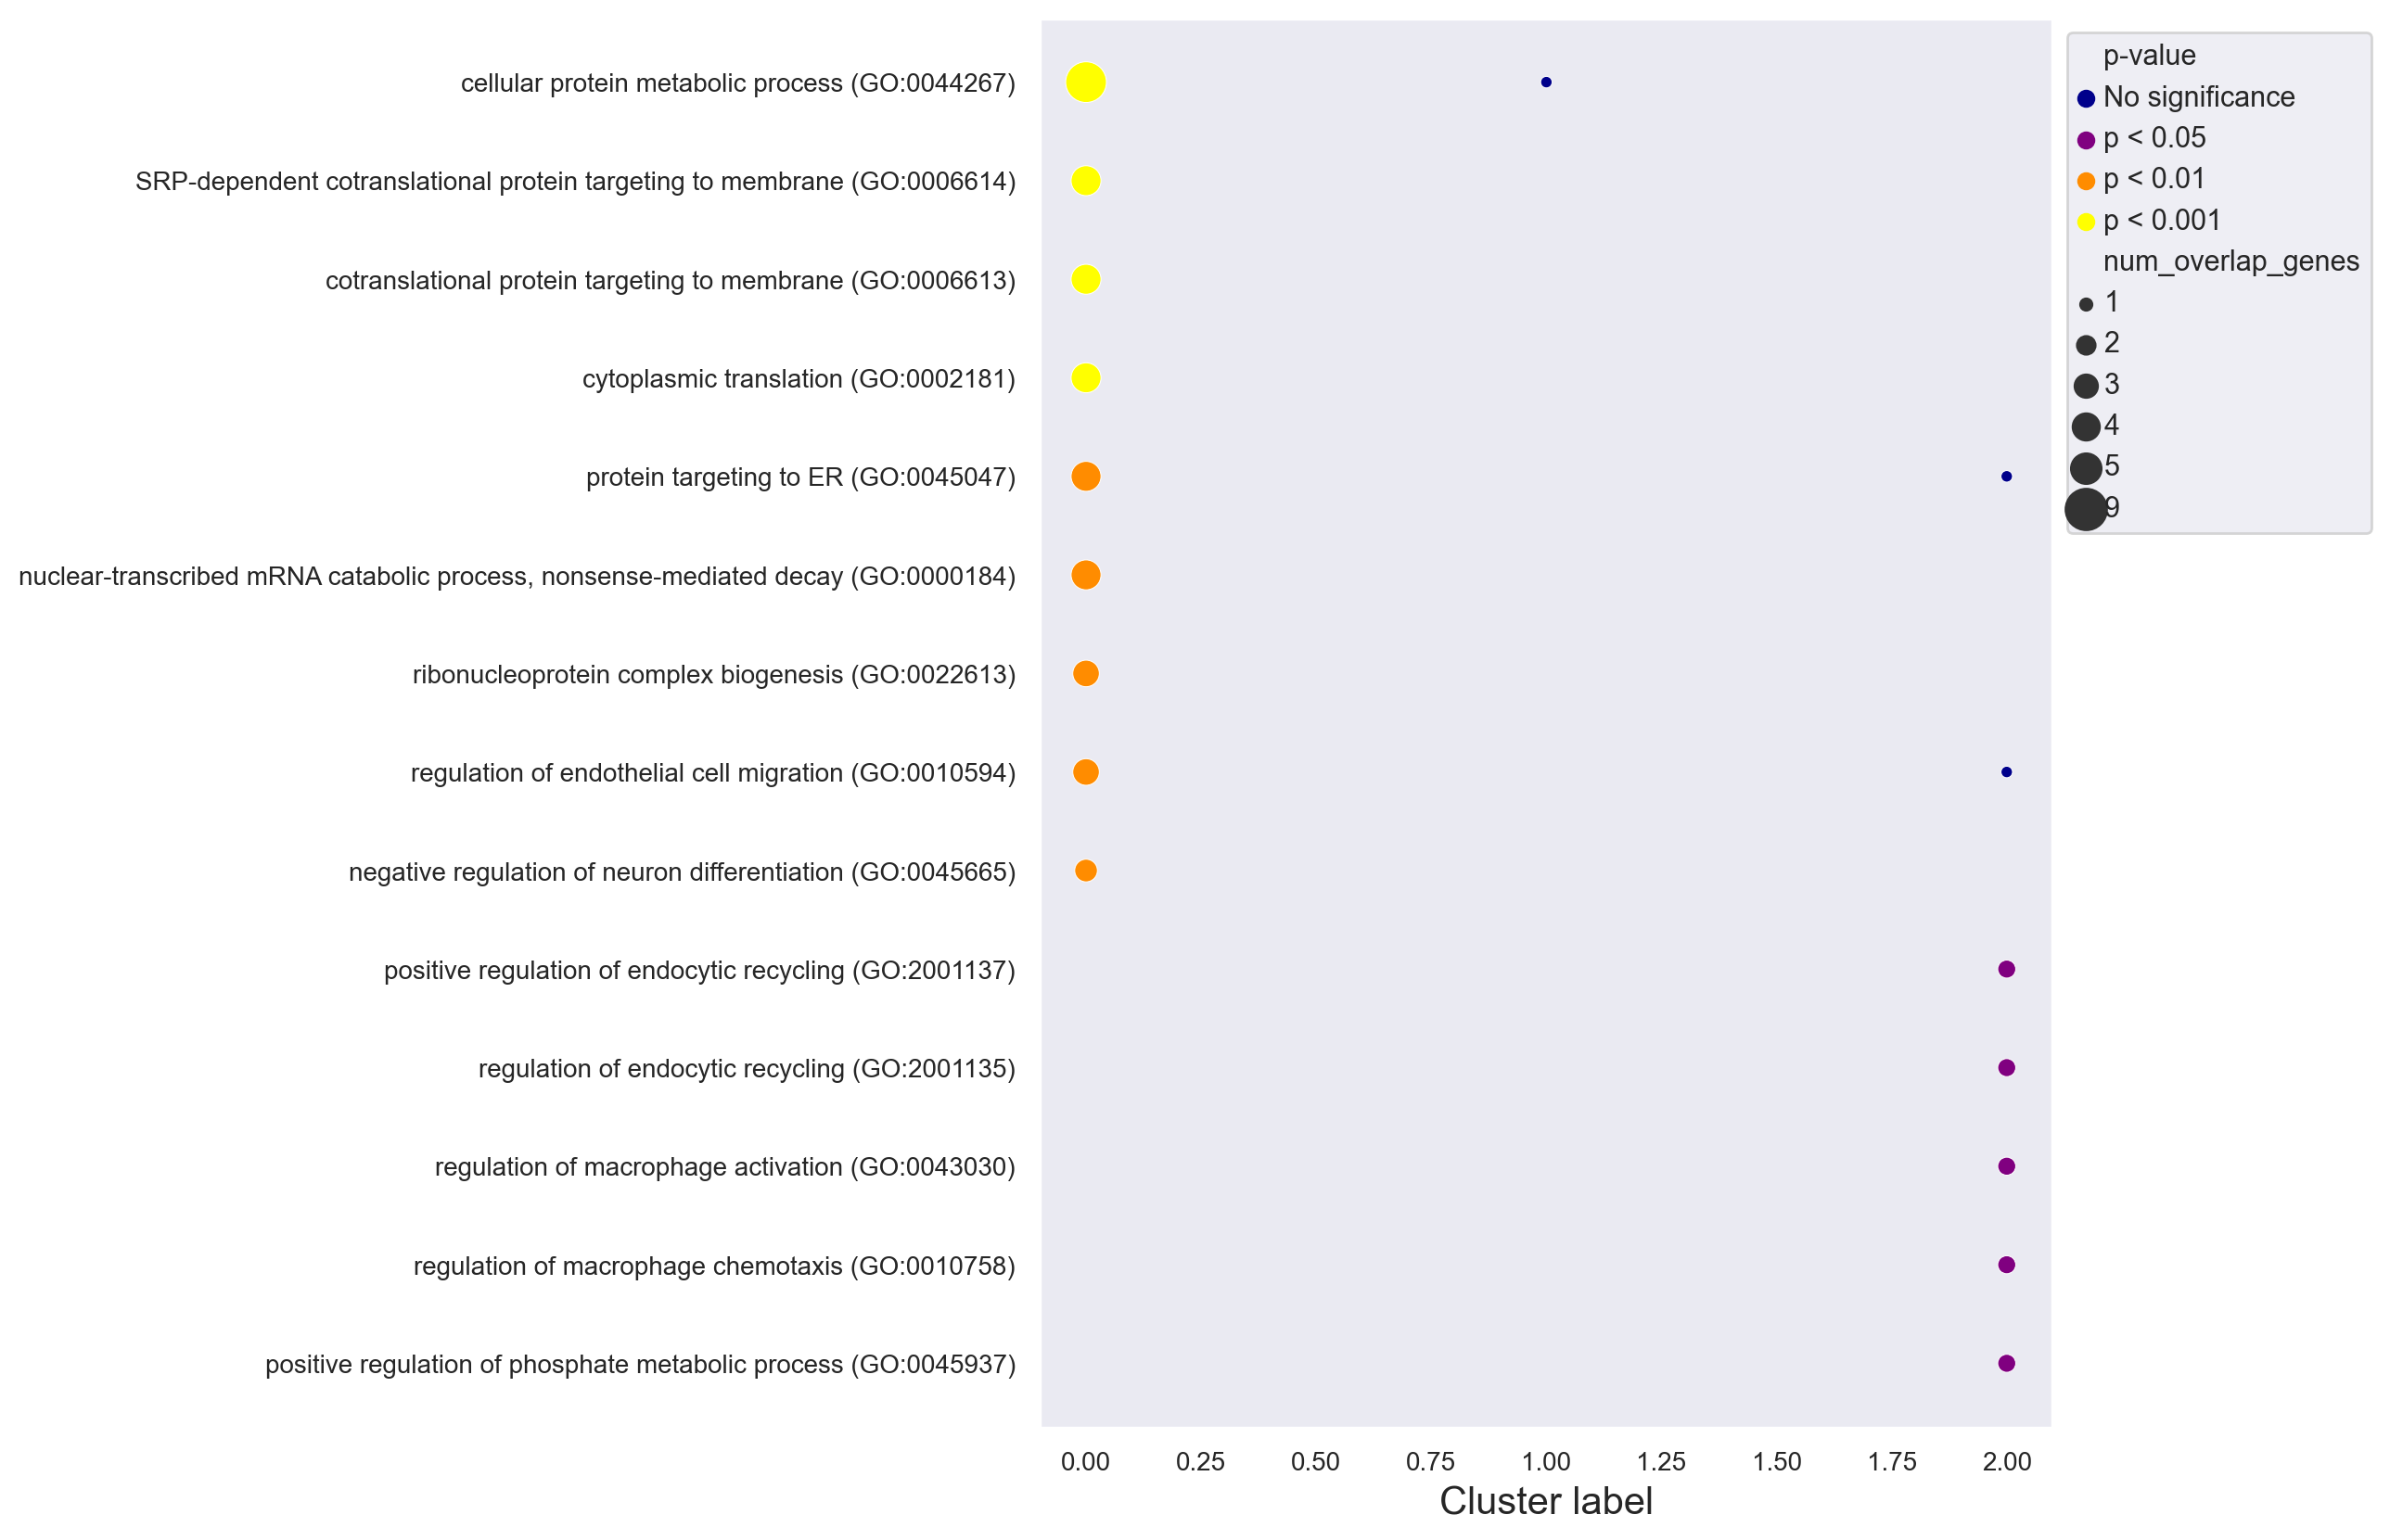

In [64]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [65]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [66]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Astrocyte CL0000127,1,0.000089,269.705882,2516.326852,"[CST3, SLC1A3]",0.003638,0,0,2,2.439137,0
Memory Regulatory T CL0000815,2,0.003910,inf,inf,[B2M],0.029982,0,0,1,1.523136,0
CD8+ Memory/Effector T CL0000625,3,0.007804,262.028571,1271.644492,[RPL34],0.029982,0,0,1,1.523136,0
Basophil/Mast CL0000766,4,0.007804,262.028571,1271.644492,[KIT],0.029982,0,0,1,1.523136,0
CD4+ Cytotoxic T CL0000934,5,0.007804,262.028571,1271.644492,[B2M],0.029982,0,0,1,1.523136,0


In [67]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

27

In [68]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

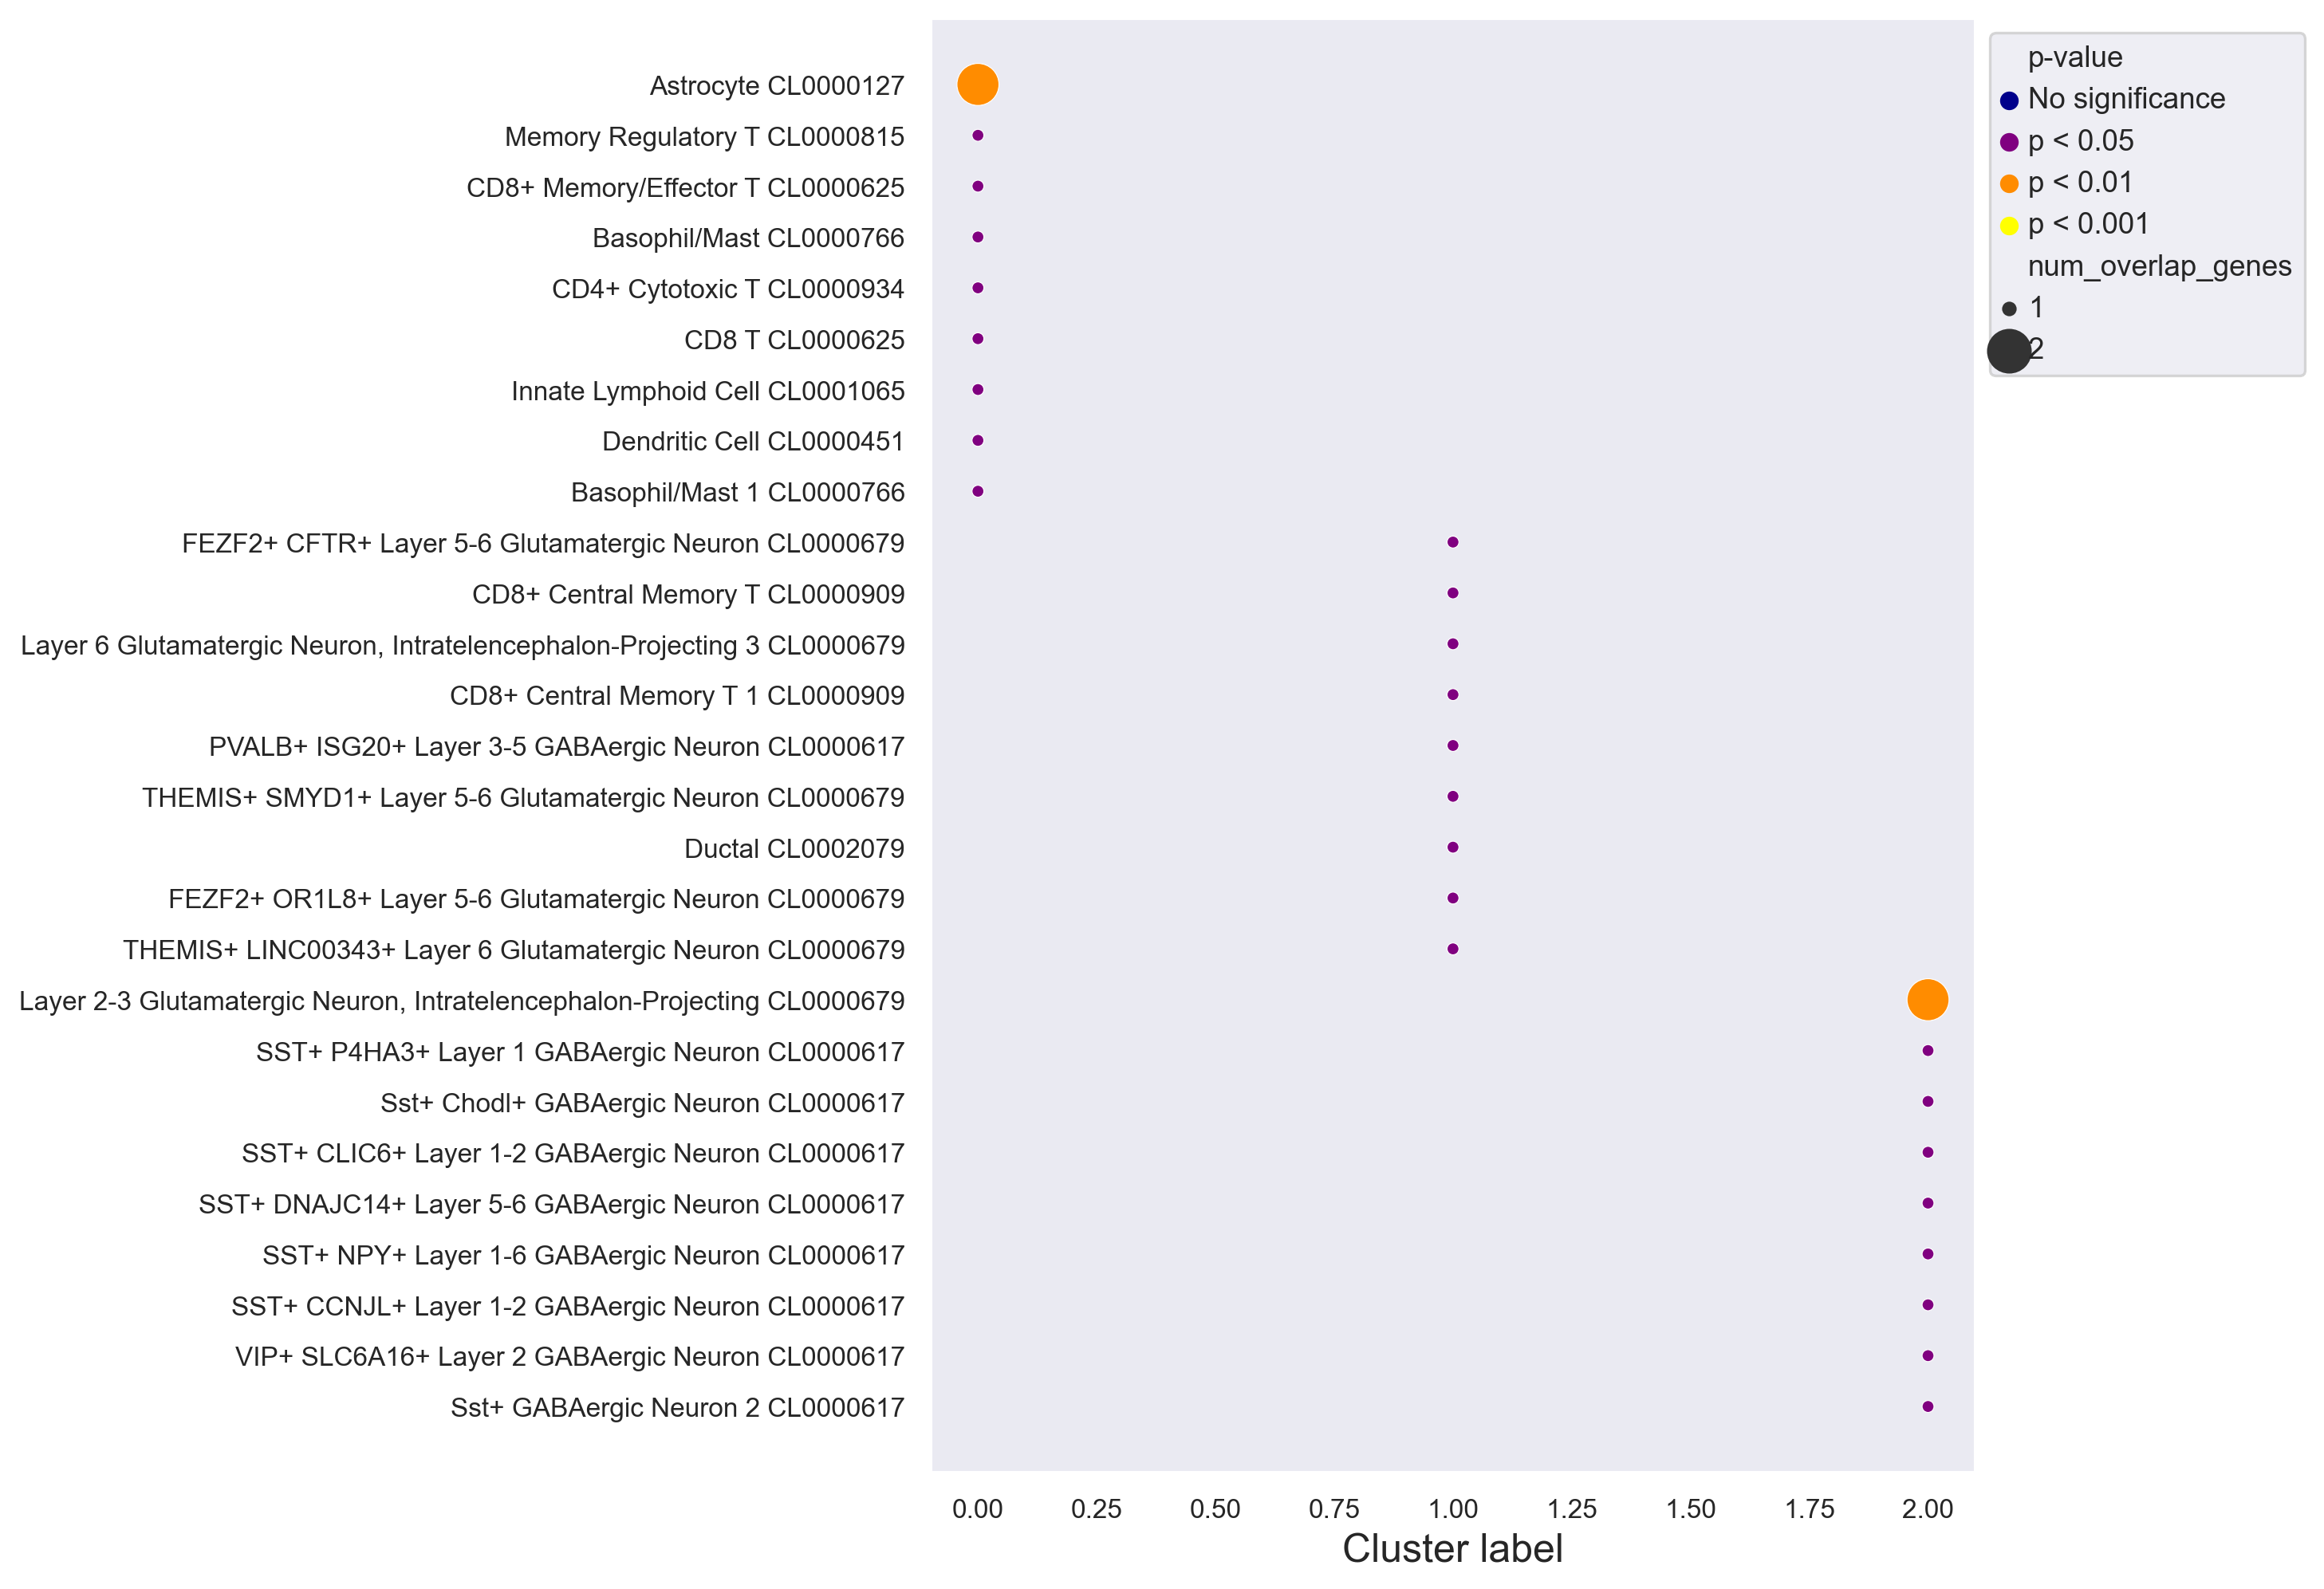

In [69]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [70]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [71]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
increased sensitivity to induced morbidity/mortality MP:0009763,1,0.000007,22.253177,262.904704,"[CAV1, KIT, TXNIP, VIM, TIMP1]",0.005926,0,0,5,2.227233,0
impaired neutrophil recruitment MP:0008719,2,0.000030,64.048951,667.712078,"[CAV1, KIT, PTN]",0.011485,0,0,3,1.939853,0
abnormal humerus morphology MP:0005296,3,0.000043,55.496970,557.962333,"[SPARC, RPL38, TIMP1]",0.011485,0,0,3,1.939853,0
conductive hearing loss MP:0004739,4,0.000148,179.784314,1585.972085,"[DLX1, RPL38]",0.018329,0,0,2,1.736856,0
abnormal astrocyte morphology MP:0002182,5,0.000168,33.261818,289.072554,"[SERPINE2, CAV1, VIM]",0.018329,0,0,3,1.736856,0


In [72]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

28

In [73]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

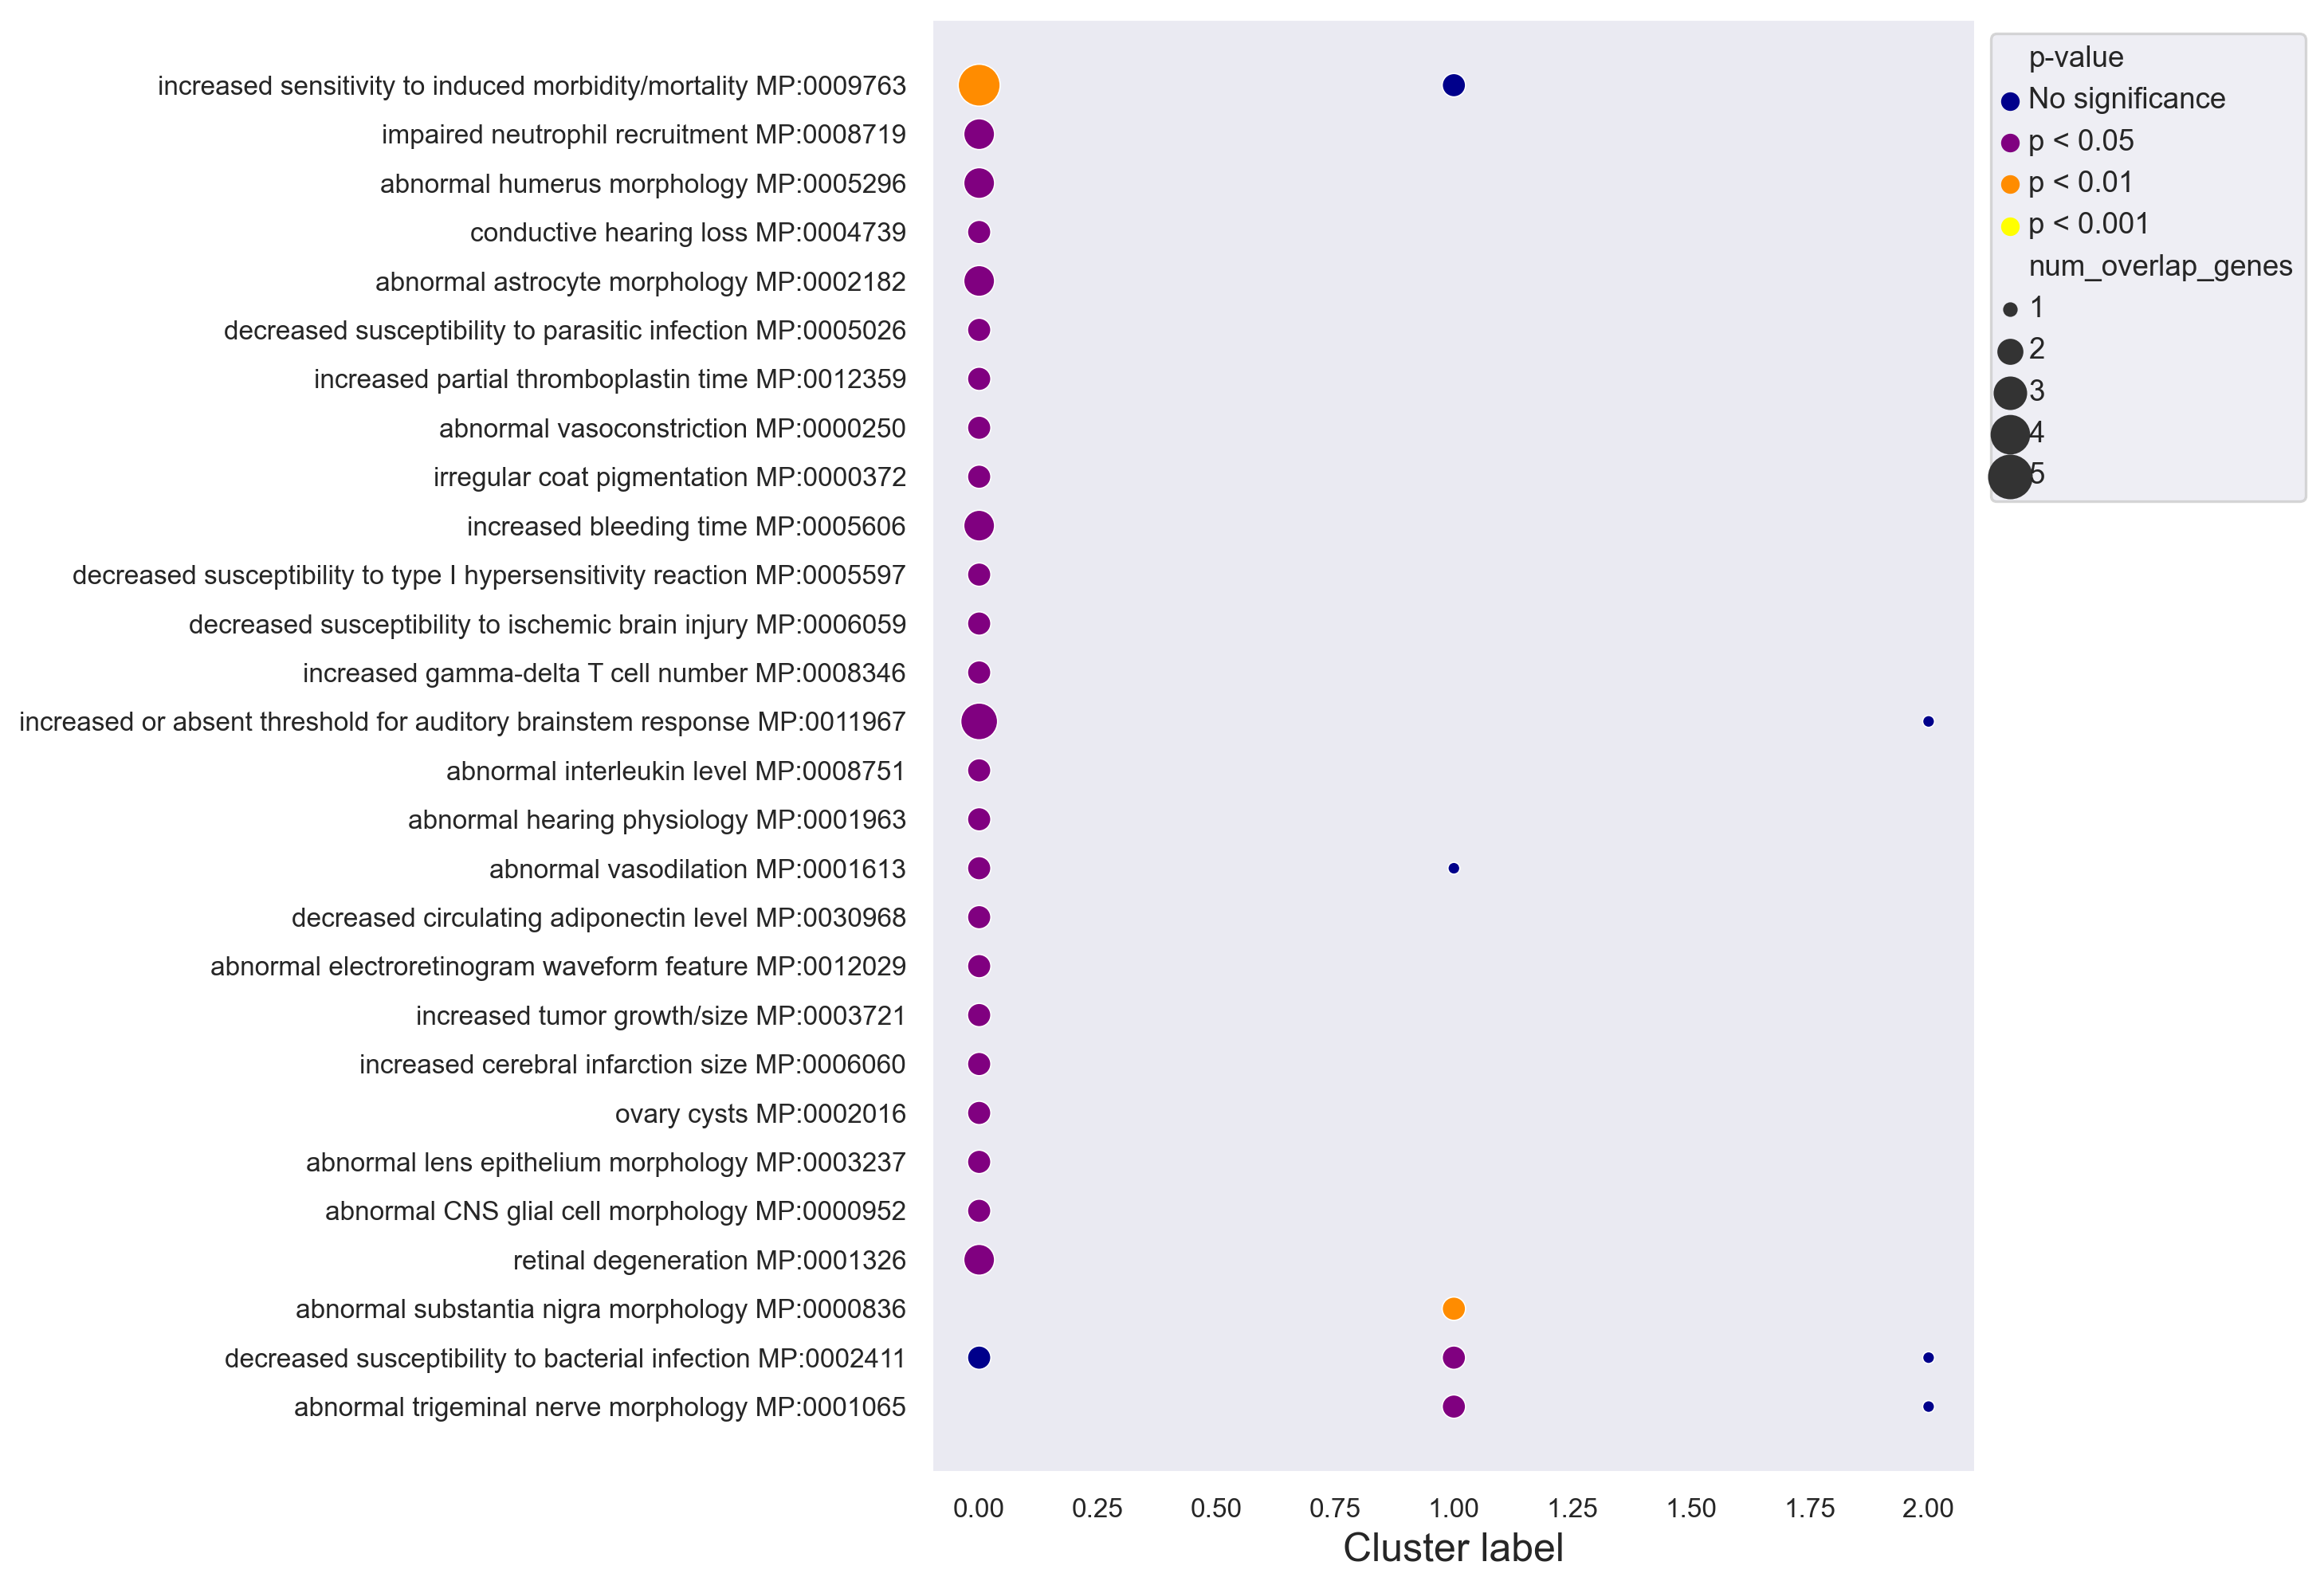

In [74]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [75]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [76]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Influenza Infection R-HSA-168255,1,1.797384e-07,21.253097,330.098071,"[NUP93, RPS29, RPL34, RPL38, CALR, RPL26, RPS24]",0.000051,0,0,7,4.292041,0
Influenza Viral RNA Transcription And Replication R-HSA-168273,2,1.560614e-06,20.411236,272.907020,"[NUP93, RPS29, RPL34, RPL38, RPL26, RPS24]",0.000123,0,0,6,3.908578,0
Peptide Chain Elongation R-HSA-156902,3,2.264051e-06,28.845667,374.946218,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000123,0,0,5,3.908578,0
Selenocysteine Synthesis R-HSA-2408557,4,2.700647e-06,27.751065,355.824690,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000123,0,0,5,3.908578,0
Eukaryotic Translation Termination R-HSA-72764,5,2.700647e-06,27.751065,355.824690,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000123,0,0,5,3.908578,0


In [77]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [78]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

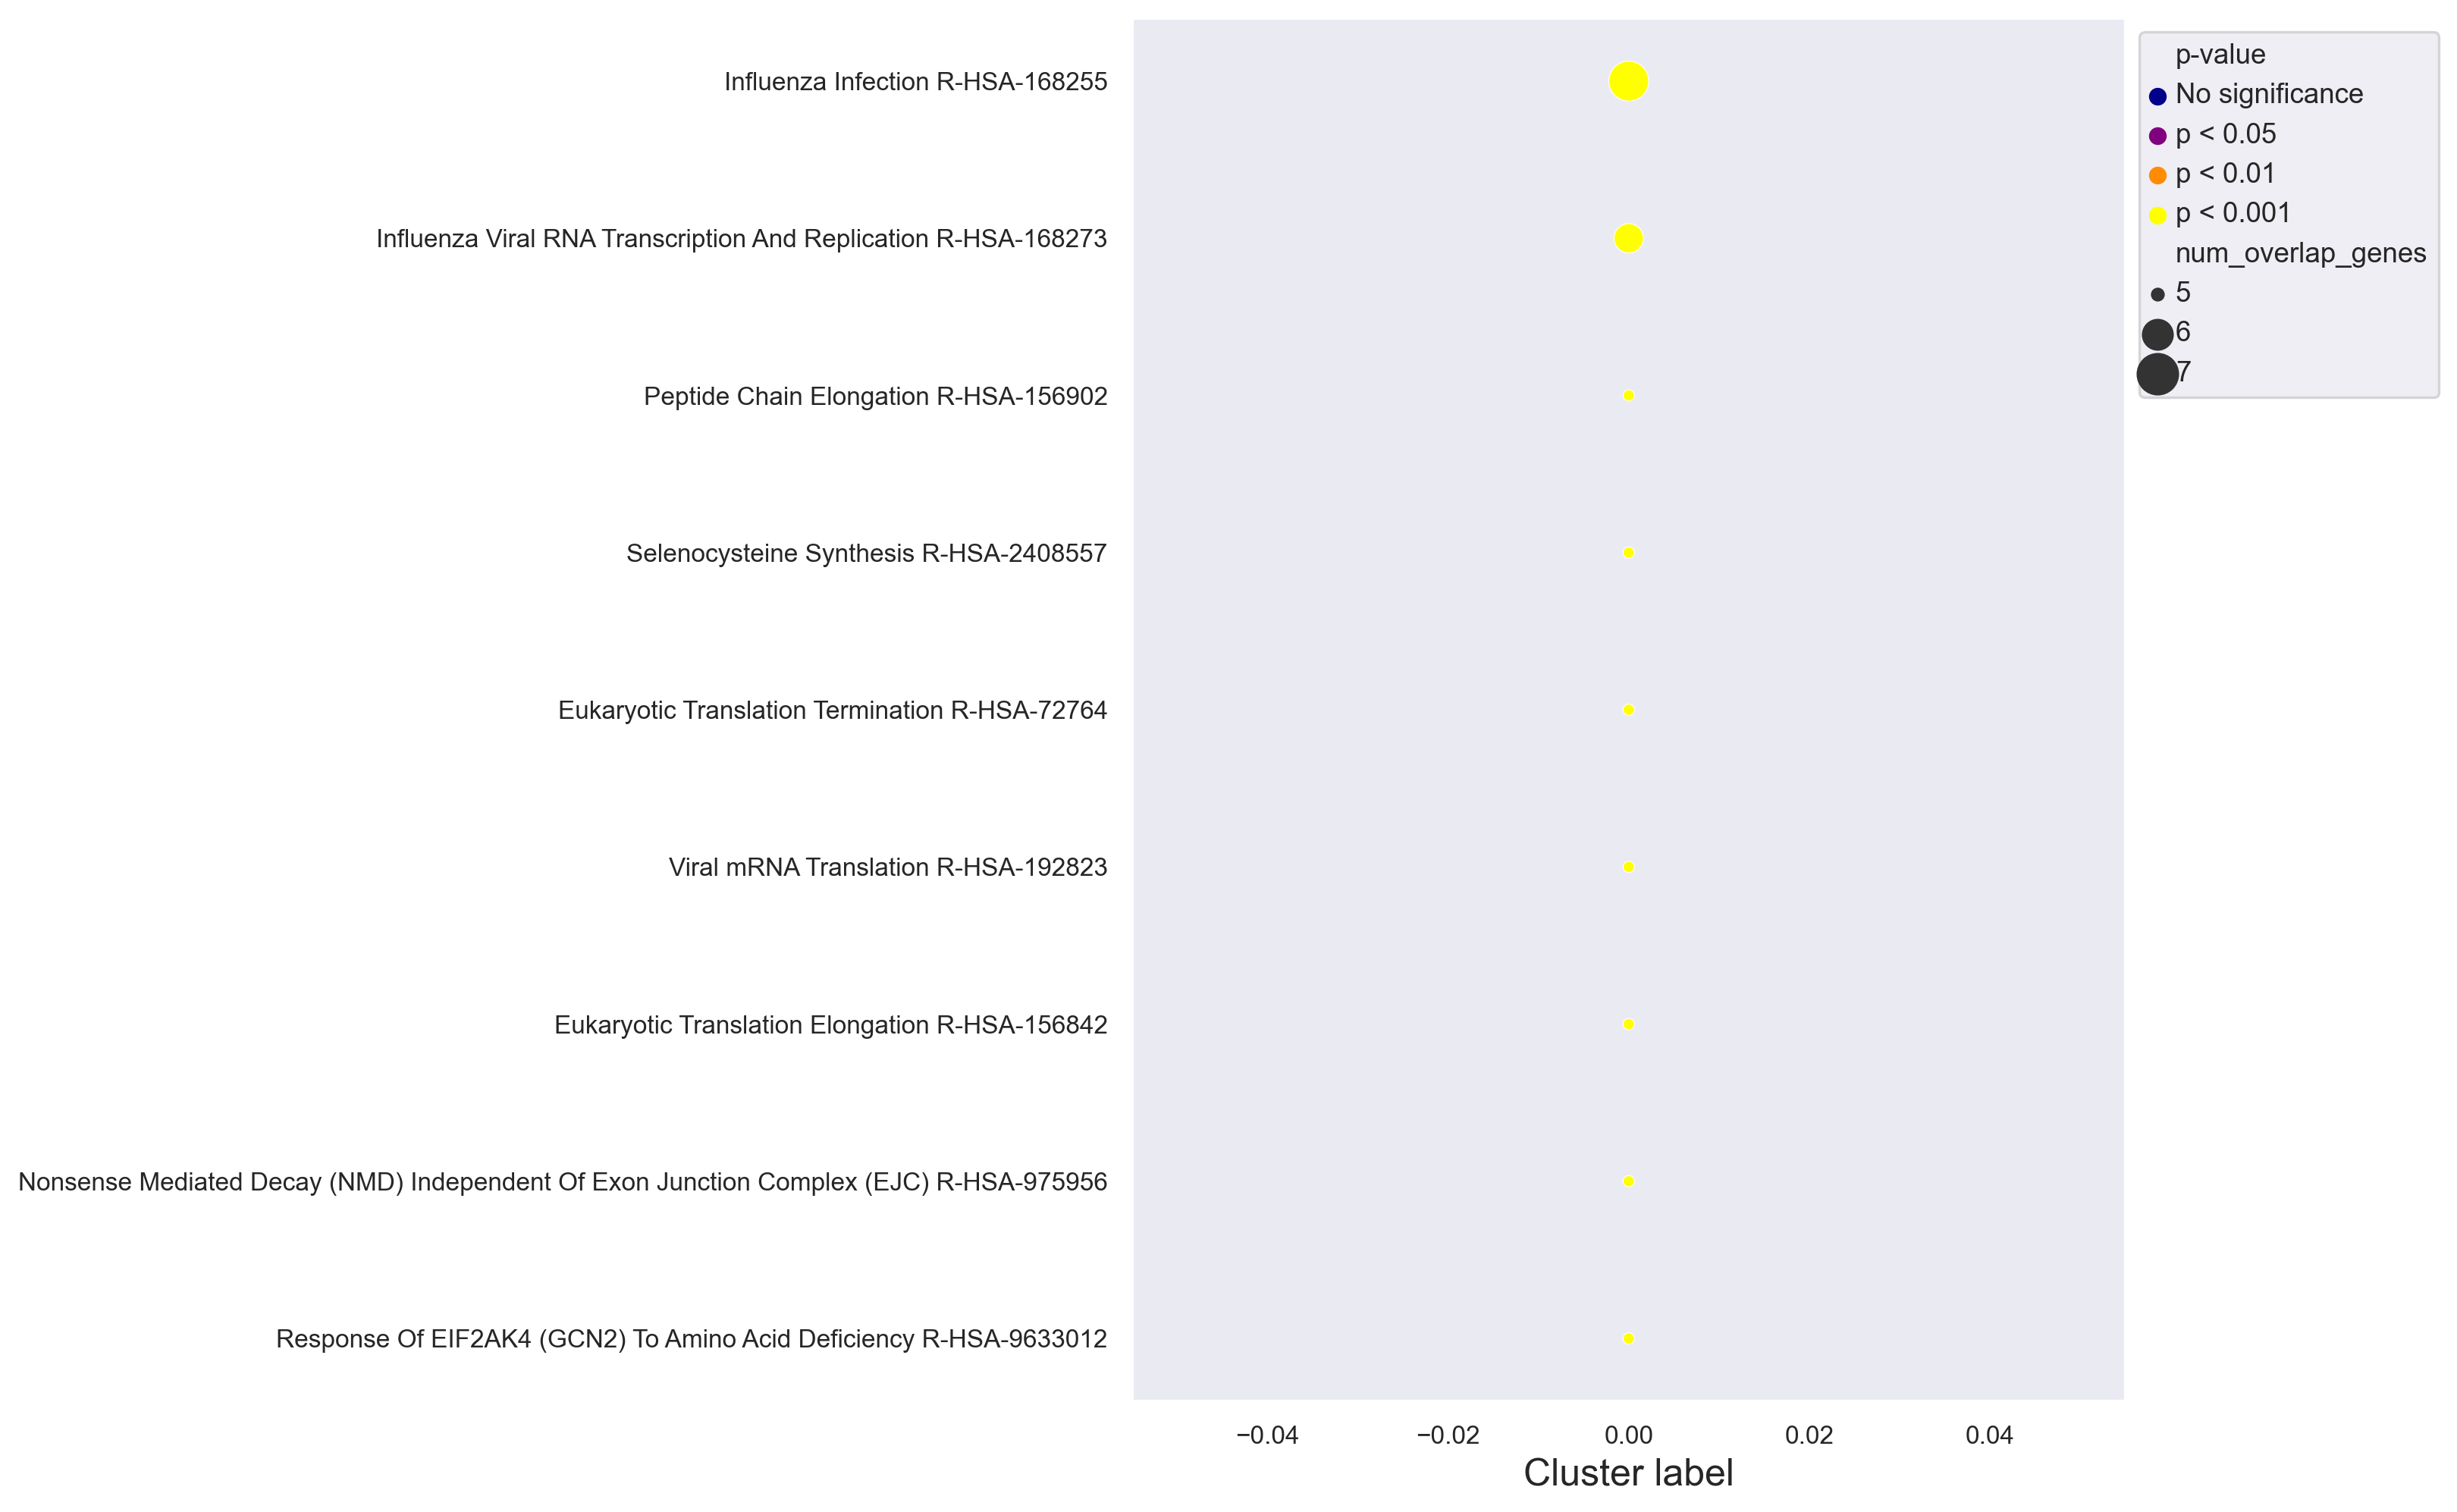

In [79]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [80]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [81]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Coronavirus disease,1,0.000005,16.326126,198.389191,"[VWF, RPS29, RPL34, RPL38, RPL26, RPS24]",0.000338,0,0,6,3.471210,0
Ribosome,2,0.000026,16.842788,177.596573,"[RPS29, RPL34, RPL38, RPL26, RPS24]",0.000843,0,0,5,3.074211,0
Antigen processing and presentation,3,0.003886,24.465241,135.791843,"[CALR, B2M]",0.082899,0,0,2,1.081449,0
ECM-receptor interaction,4,0.006848,17.925490,89.337536,"[VWF, TNC]",0.085717,0,0,2,1.066934,0
MicroRNAs in cancer,5,0.008036,8.004413,38.611924,"[TNC, VIM, EZR]",0.085717,0,0,3,1.066934,0


In [82]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

2

In [83]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

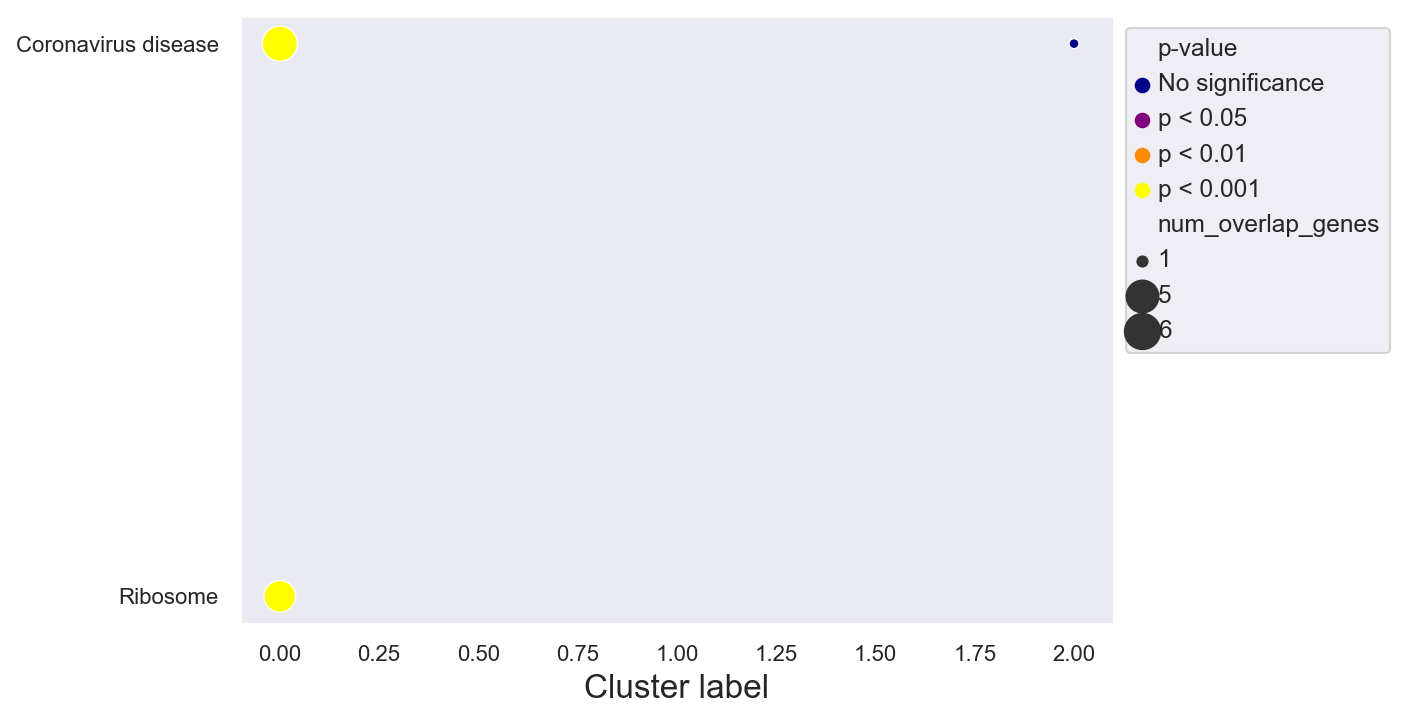

In [84]:
fig = plt.figure(figsize=(7, 5), dpi=80)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))